In [103]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.pyplot as figure
import cyipopt as ipopt

In [104]:
#Q1 (60 %) Implement investment strategies in Python:

In [105]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal
    return x_optimal, cash_optimal,final_weight,end_portvalue

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port/len(cur_prices)/cur_prices #precise number of shares ~= 1/20 weight

    #calculate the transaction cost
    #call the rounding function to get the first estimated x_optimal
    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices)) 
        position_diff=number_share_round-x_init
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1

    x_optimal=number_share_round
    cash_optimal=cash_temp
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal
    return x_optimal, cash_optimal,final_weight,end_portvalue

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices): 
    #initialize the CPLEX Object
    cpx=cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n=len(cur_prices)

   # Define linear part of objective
   # function and bounds on variables
    c=[0.0]*n
    ub=[cplex.infinity]*n
# Define constraint matrix A
    cols=[[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],
        [[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]]]
# Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs =[1.0], senses="E")
    cpx.variables.add(obj=c, ub=ub , columns=cols, names=["w1", "w2", "w3","w4", "w5", "w6","w7", "w8", "w9","w10", "w11",
                                                     "w12","w13", "w14", "w15","w16", "w17", "w18","w19","w20"])
# Define and add quadratic part of objective function
    Sparse = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Sparse)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.solve()
    
    weight=cpx.solution.get_values()
    weight_to_array=np.array(weight) 
    #up to this.. get the weight array for each stock, next is similar to equal weight strategy
 
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
        position_diff=number_share_round-x_init 
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1
    
    x_optimal=number_share_round
    cash_optimal=cash_temp    
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal
    return x_optimal, cash_optimal,final_weight,end_portvalue

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    #initialize the CPLEX Object
    cpx=cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n=len(cur_prices)
   # Define linear part of objective
   # function and bounds on variables
    c=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    ub=[cplex.infinity]*len(cur_prices) #put k here
    cols=[]
# Define constraint matrix A
 #Define the linear constraint for  1/(mu-rf) and transform the sparse matrix 
    mu_=mu-1/252*r_rf
    for k in range(20):
        cols.append([[0],[mu_[k]]])    
# Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs =[1.0], senses="E") #put k in 2nd spot
    cpx.variables.add(obj=c, ub=ub , columns=cols, names=["y1", "y2", "y3","y4", "y5", "y6","y7", "y8", "y9","y10", "y11",
                                                     "y12","y13", "y14", "y15","y16", "y17", "y18","y19","y20"])

# Define and add quadratic part of objective function
    Sparse = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]

    cpx.objective.set_quadratic(Sparse)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.solve()
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal=x_init
        cash_optimal=cash_init    
        final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
        end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal
        return x_optimal, cash_optimal,final_weight,end_portvalue
    else:
        
        y_=cpx.solution.get_values() # this is vector y
        y_array=np.array(y_) 
        weight=y_array/np.sum(y_array) #convert to weight vector
    #up to this.. get the weight array for each stock, next is similar to min_variance
 
        continue_the_loop=1
        V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
        iteration_times=0
        number_share_raw=V_port*weight/cur_prices #precise number of shares V*weight/cur_price

        while continue_the_loop==1:
            number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
            position_diff=number_share_round-x_init 
            trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
            cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
            if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
                continue_the_loop=0
            else:
                continue_the_loop=1
                iteration_times=iteration_times+1
    
        x_optimal=number_share_round
        cash_optimal=cash_temp
        final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
        end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal
        return x_optimal, cash_optimal,final_weight,end_portvalue

def rounding (x_position_raw,times,number_of_stock):
    number_share_round=np.zeros(number_of_stock)
    for i in range(number_of_stock):
        number_share_round[i]=math.floor(x_position_raw[i])-times
        if number_share_round[i]<0: # round up to 0 if it is negative number
            number_share_round[i]=0
    
    return number_share_round

def strat_min_variance_2(x_init, cash_init, mu, Q, cur_prices): 
    #initialize the CPLEX Object
    cpx=cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n=len(cur_prices)

   # Define linear part of objective
   # function and bounds on variables
    c=[0.0]*n
    ub=[cplex.infinity]*n
# Define constraint matrix A
    cols=[[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],
        [[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]],[[0],[1]]]
# Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs =[1.0], senses="E")
    cpx.variables.add(obj=c, ub=ub , columns=cols, names=["w1", "w2", "w3","w4", "w5", "w6","w7", "w8", "w9","w10", "w11",
                                                     "w12","w13", "w14", "w15","w16", "w17", "w18","w19","w20"])
# Define and add quadratic part of objective function
    Sparse = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Sparse)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.solve()
    
    weight=cpx.solution.get_values()
    weight_to_array=np.array(weight) 
    #up to this.. get the weight array for each stock, next is similar to equal weight strategy
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
        position_diff=number_share_round-x_init 
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1
    
    x_optimal=number_share_round
    cash_optimal=cash_temp    
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    return final_weight

In [106]:
# Define objective function, constraints, gradient of objective fucntion,
#and jacobian of constrants for the ERC problem.

class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(20)
        # Insert your gradient computations here; this is analytical solution
        ##Start Comment/uncomment here##
       #------------------------------------------------# 
        y = x * np.dot(Q, x) # y is in 20x1 matrix 
        for i in range(20):
            for j in range (20):
                for k in range (j+1,20):
                    if j==i:
                        diff1=np.dot(Q[i],x)+Q[i,i]*x[i]
                        diff2=Q[k,j]*x[k]
                        grad[i]=grad[i]+(y[j]-y[k])*(diff1-diff2)
                    elif k==i:
                        diff1=Q[j,k]*x[j]
                        diff2=np.dot(Q[i],x)+Q[i,i]*x[i]
                        grad[i]=grad[i]+(y[j]-y[k])*(diff1-diff2)     
                    else:
                        diff1=Q[j,i]*x[j]
                        diff2=Q[k,i]*x[k]
                        grad[i]=grad[i]+(y[j]-y[k])*(diff1-diff2)                       
        grad[i]=2*2*grad[i]
        #-------------------------comment up to here. ------------------------------#
        # You can use finite differences to check the gradient
        #uncomment from here; this is symmetrical approximation
        
#         h=0.001
        
#         for i in range(20):
#             x_plus=x
#             x_minus=x
#             x_plus[i]=x_plus[i]+h
#             x_minus[i]=x_minus[i]-h
#             y1=x_plus * np.dot(Q, x_plus)
#             y2=x_minus * np.dot(Q, x_minus)
#             for j in range(20):
#                 for k in range (j+1,20):
#                     diff1=(y1[j]-y2[k])**2
#                     #diff2=(y2[j]-y2[k])**2
#                     grad[i]=grad[i]+(diff1)/2/h
#         grad[i]=grad[i]
                    
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * 20
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])


In [107]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):  
   # Use wo(1/n) as initial portfolio for starting IPOPT optimization 
    n=len(cur_prices)
    w0 = [1.0/n] * n
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
# Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
   #Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('sb', 'yes')
    nlp.add_option('print_level', 0)
# Solve the problem
    weight_to_array, info = nlp.solve(w0)
    std_ERC= np.sqrt(np.dot(weight_to_array, np.dot(Q, weight_to_array)))
    RC_ERC = (weight_to_array* np.dot(Q, weight_to_array)) / std_ERC
# up to here we got the w weight (in array form)
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
        position_diff=number_share_round-x_init 
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1
    
    x_optimal=number_share_round
    cash_optimal=cash_temp    
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal

    return x_optimal, cash_optimal,final_weight,end_portvalue

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices,pay_back_bank):
   # Use wo(1/n) as initial portfolio for starting IPOPT optimization 
    n=len(cur_prices)
    w0 = [1.0/n] * n
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

# Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
   #Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('sb', 'yes')
    nlp.add_option('print_level', 0)
# Solve the problem
    weight_to_array, info = nlp.solve(w0)
    std_ERC= np.sqrt(np.dot(weight_to_array, np.dot(Q, weight_to_array)))
    RC_ERC = (weight_to_array* np.dot(Q, weight_to_array)) / std_ERC

# up to here we got the w weight (in array form - weight_to_array)
    
#calculate the adjusted V_port after pay back the interest and borrowed part; 
#cases 1 : period 1    - borrow->buy 200%
#Cases 2: period 2 to 12 - payback first (sell all the short positions and pay back the bank with interest) ->
############              -> find the adjust number of stock -> borrow->buy 200%
    
    if period ==1:
        V_port=np.dot(cur_prices,x_init)
        V_borrow=V_port
        continue_the_loop=1
        iteration_times=0
        number_share_raw=V_port*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

        while continue_the_loop==1:
            number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
            position_diff=number_share_round*2-x_init 
            trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
            cash_temp=V_port+V_borrow-(trans_cost+np.dot(number_share_round*2,cur_prices))+cash_init
    
            if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
                continue_the_loop=0
            else:
                continue_the_loop=1
                iteration_times=iteration_times+1
    
        x_optimal=number_share_round*2
        cash_optimal=cash_temp    
        final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
        end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal-V_borrow
        return x_optimal, cash_optimal,final_weight,V_borrow,end_portvalue
        
    else:
        V_port_origianl=np.dot(cur_prices,x_init/2) #portfolio 100% this part is for long portion 
        V_port_borrow=np.dot(cur_prices,x_init/2) #portfolio 100% this part is for short portfolio
        borrow_rate=r_rf/6
        totoal_payback=pay_back_bank*(1+borrow_rate)
        TC=V_port_borrow*0.005  # sell all the short portions to return to the bank
        
#the profit from shorting the postion can be negative or positive, 
#if the cash account is negative then will sell more stock
#if the profit is postive then accumulate in the Cash Account
        cash_init=V_port_borrow-totoal_payback-TC+cash_init  
# two cases.. if is negative then sell more stocks;else keep the CA as flowing account
        if cash_init<0:
            margin=cash_init  #this is the extra money needs to recover the negative cash account
            continue_the_loop=1
            iteration_times=1
            while continue_the_loop==1:
                temp_ones=np.ones(len(cur_prices))*iteration_times
                sell_one_each_stock=np.dot(cur_prices,temp_ones)
                if sell_one_each_stock-sell_one_each_stock*0.005+margin>0:
                    continue_the_loop=0 #stop the while loop if sell_one_each_stock>margin
                    cash_init=sell_one_each_stock-sell_one_each_stock*0.005+margin # new cash_init
                else:
                    continue_the_loop=1
                    iteration_times=iteration_times+1
            # the number of oversold stocks 
            x_init_adjust=x_init/2-iteration_times 
        # if cash_init>0 then only keep the long portions
        else: 
            x_init_adjust=x_init/2
       
        new_borrow_asset=np.dot(x_init_adjust,cur_prices)
        V_port_adjust=new_borrow_asset
    
    
        continue_the_loop=1
        iteration_times=0
        number_share_raw=V_port_adjust*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

        while continue_the_loop==1:
            number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
            position_diff=(number_share_round*2-x_init)  #twice the number since borrow more assets from the bank
            trans_cost=np.dot(abs(position_diff),cur_prices)*0.005 # TC includes the 
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        
            cash_temp=V_port_origianl+V_port_borrow-(trans_cost+np.dot(number_share_round*2,cur_prices))+cash_init
    
            if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
                continue_the_loop=0
            else:
                continue_the_loop=1
                iteration_times=iteration_times+1
    
        x_optimal=number_share_round*2
        cash_optimal=cash_temp    
        final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
        end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal-new_borrow_asset
        return x_optimal, cash_optimal,final_weight,new_borrow_asset,end_portvalue


def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
# Define initial portfolio ("equally weighted" or "1/n portfolio")
    n=len(cur_prices)
    w0=[1.0/n]*n
    ret_init=np.dot(mu,w0)   #1/n portfolio return
    var_init=np.dot(w0,np.dot(Q,w0)) #1/n portfolio var
    
# Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    
# Target portfolio return estimation error is return estimation error of 1/n portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init # target return estimation error
#compute the minimum variance 
    w_MVP=strat_min_variance_2(x_init, cash_init, mu, Q, cur_prices)
    ret_minVar = np.dot(mu, w_MVP)
# Target portfolio return is return of minimum variance portfolio
    Portf_Retn = ret_minVar

#formulate the robust miean-variance problem
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A=[]
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
#print("Setting number of threads = ", 4)
    cpx.parameters.timelimit.set(60)
#print("Setting timelimit = ", 60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
#print("Setting Barrier algorithm convergence tolerance = ", 1e-12)
    cpx.set_results_stream(None)
    cpx.solve()

    weight=cpx.solution.get_values()
    weight_to_array=np.array(weight) 
    #up to this.. get the weight array for each stock, next is similar to equal weight strategy
 
    continue_the_loop=1
    V_port=np.dot(cur_prices,x_init) #total portfolio is equal to asset market valus
    iteration_times=0
    number_share_raw=V_port*weight_to_array/cur_prices #precise number of shares V*weight/cur_price

    while continue_the_loop==1:
        number_share_round=rounding(number_share_raw,iteration_times,len(cur_prices))
    #the return values of number_share_round will be at least zero (non-negative number)
        position_diff=number_share_round-x_init 
        trans_cost=np.dot(abs(position_diff),cur_prices)*0.005
    
    #calculate the leftover money after paying the TC and values of rebalancing
    #before balancing+cash_initial - after balancing - TC is the leftover,
    #if it is positive, then accumulate in CA
    #otherwise, continue to round down the x_optimal to ensure the enough cash
        cash_temp=V_port-(trans_cost+np.dot(number_share_round,cur_prices))+cash_init
    
        if cash_temp>0: #stop the big while loop if cash is positive and no need to re-iterate the rounding procedures
            continue_the_loop=0
        else:
            continue_the_loop=1
            iteration_times=iteration_times+1
    
    x_optimal=number_share_round
    cash_optimal=cash_temp    
    final_weight=x_optimal*cur_prices/np.dot(x_optimal,cur_prices)
    end_portvalue=np.dot(x_optimal,cur_prices)+cash_optimal
    return x_optimal, cash_optimal,final_weight,end_portvalue

In [110]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat =len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
weight_opt = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
portf_value_each_period = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
borrow_amount = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         payback=0.0
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]
         payback=borrow_amount[strategy, period-2]
        


      
 #subtract the borrow asset because it shall be paid back by end of each period
                      #when calculating p_values for leverage ERC method so that each strategy can be compared properly
      if strategy==5:
            # Compute strategy
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1],borrow_amount[strategy, period-1],portf_value_each_period[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices,payback)
            # Compute portfolio value
         p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]-borrow_amount[strategy, period-1]
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
         print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      else:
            # Compute strategy
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1],portf_value_each_period[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
            # Compute portfolio value
         p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
         print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        
        
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)
    

##Q2 (20 %) Analyze your results:
#Produce the following output for the 12 periods (years 2020 and 2021):



Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990890.03, value end = $ 892446.80
  Strategy "Mininum Variance Portfolio", value begin = $ 992757.75, value end = $ 915865.09
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.02, value end = $ 922031.08
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991756.52, value end = $ 897799.12
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 988132.93, value end = $ 799927.30
  Strategy "Robust Optimization Portfolio", value begin = $ 992169.43, value end = $ 917171.18

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 930705.94, value end = $ 861861.09
  Strategy "Minin

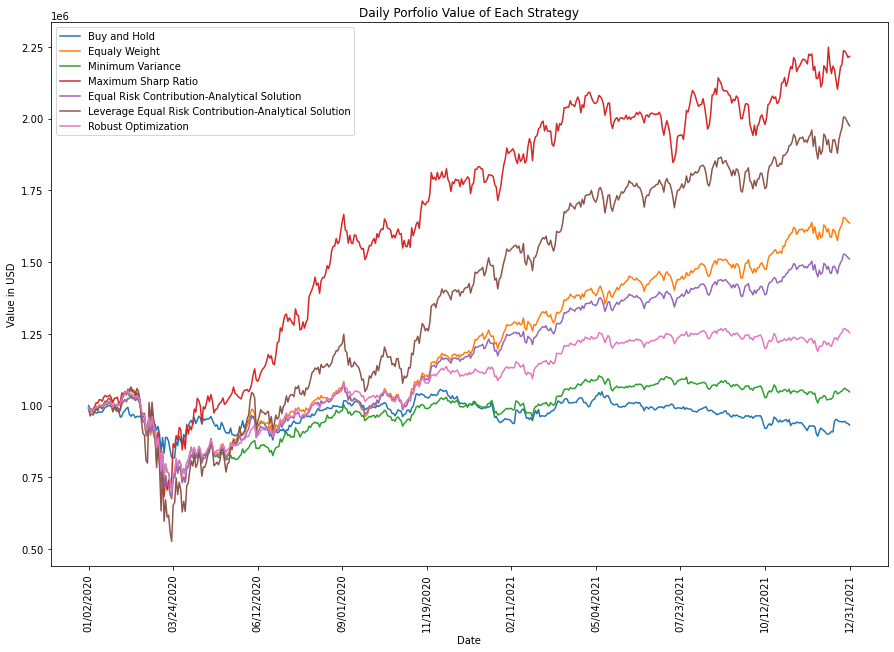

In [109]:
#Q2 (15 %) Analyze your results:
# Plot results
# one plot show daily portfolio for all strategy

plt.figure(figsize=(15,10))

plt.xlabel('Date')
plt.ylabel('Value in USD')
plt.plot(dates,portf_value[0],label='Buy and Hold')
plt.plot(dates,portf_value[1],label='Equaly Weight')
plt.plot(dates,portf_value[2],label='Minimum Variance')
plt.plot(dates,portf_value[3],label='Maximum Sharp Ratio')
plt.plot(dates,portf_value[4],label='Equal Risk Contribution-Analytical Solution')
plt.plot(dates,portf_value[5],label='Leverage Equal Risk Contribution-Analytical Solution')
plt.plot(dates,portf_value[6],label='Robust Optimization')
plt.title('Daily Porfolio Value of Each Strategy')
plt.xticks(list(dates[k] for k in list(np.linspace(0,504,10,dtype=int))),rotation=90)
plt.legend()
plt.show()

In [70]:
    # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
# each strategy function has implemented while loop to check if the remain CA cash account is positive..
# here is just to show this is hold by showing the cash array, it is all postivie
cash

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1684.8566966915969, 3997.147075617453, 4521.5974137117155,
        4949.418017673655, 7087.652822425473, 10561.651681482908,
        13097.13060613873, 15912.735898230108, 19183.55266506446,
        24200.34431271802, 26831.5262870671, 31243.294032523758],
       [1115.910209636786, 91.82063468231354, 529.695198938949,
        472.3650456428295, 1835.8097711943556, 145.70498405443504,
        2871.1560396193527, 3398.7846925543854, 243.56248529430013,
        566.5903973769164, 5565.887363219052, 5068.600431418163],
       [296.19903583533596, 13.93597646721173, 389.122475643293,
        664.1903010226088, 1870.4628222800093, 91.76077568309847,
        409.78309323091526, 1595.8356512860628, 3486.6291498307837,
        42.945823071408086, 334.47012855799403, 208.4439001682913],
       [2572.826185226557, 3156.9017965890234, 5809.348575916374,
        6741.985144665348, 7985.921421606676, 7992.47396531119,
        7587.547587628476, 1

In [71]:
##Q2 (15 %) Analyze your results:
#Plot one chart in Python that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 12 periods

df_portvalue=pd.DataFrame(portf_value_each_period.T.tolist(),columns=strategy_names)
df_portvalue

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio Portfolio,Equal Risk Contributions Portfolio,Leveraged Equal Risk Contributions Portfolio,Robust Optimization Portfolio
0,1.000013e+06,9.908900e+05,9.927578e+05,9.900640e+05,9.917565e+05,9.881329e+05,9.921694e+05
1,9.450761e+05,9.307059e+05,9.557118e+05,9.619348e+05,9.373491e+05,1.011284e+06,9.589810e+05
2,9.379168e+05,8.306776e+05,8.263841e+05,9.742422e+05,8.227470e+05,7.906259e+05,8.364464e+05
3,9.054196e+05,9.268764e+05,8.557534e+05,1.219498e+06,9.137738e+05,9.526144e+05,9.231530e+05
4,9.931945e+05,1.066722e+06,9.826162e+05,1.641529e+06,1.060604e+06,1.216297e+06,1.055032e+06
5,9.838010e+05,1.006774e+06,9.506075e+05,1.553287e+06,1.003991e+06,1.102837e+06,1.018182e+06
6,1.005601e+06,1.178001e+06,1.003358e+06,1.738801e+06,1.165254e+06,1.392378e+06,1.109453e+06
7,9.577914e+05,1.293272e+06,9.747174e+05,1.902697e+06,1.241915e+06,1.523800e+06,1.115926e+06
8,1.022205e+06,1.391993e+06,1.087146e+06,2.053396e+06,1.351079e+06,1.714766e+06,1.233205e+06
9,9.932835e+05,1.459860e+06,1.076126e+06,2.014783e+06,1.387416e+06,1.770434e+06,1.233204e+06


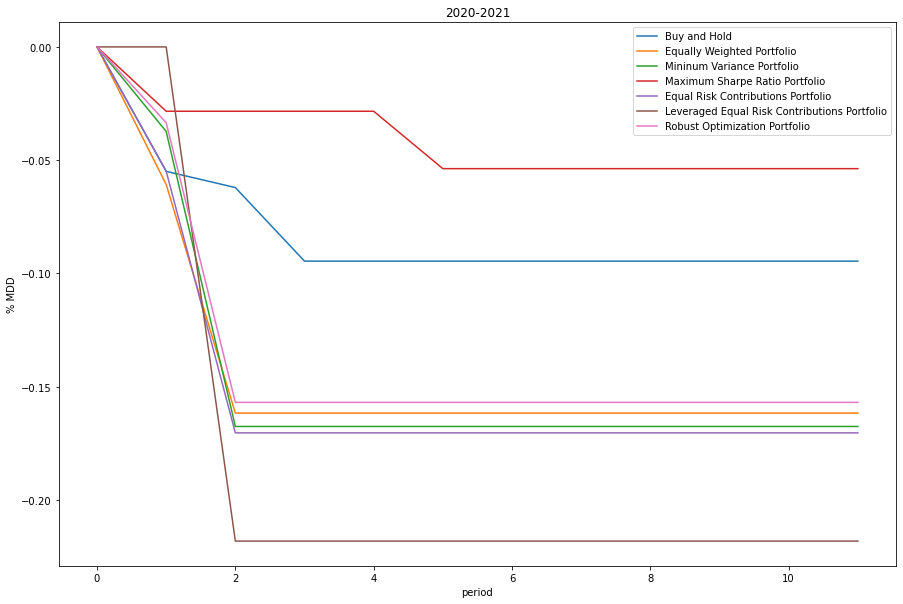

In [72]:
plt.figure(figsize=(15,10))
plt.ylabel('% MDD')
plt.xlabel('period')
plt.title('2020-2021')

for i in range (7):
    temp_letter=strategy_names[i]
    
    Roll_Max = df_portvalue[temp_letter].rolling(12, min_periods=1).max()
    Daily_Drawdown = df_portvalue[temp_letter]/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.rolling(12, min_periods=1).min()

    Max_Daily_Drawdown.plot(label=temp_letter)
    plt.legend()
 

plt.show()

In [73]:
df

,Date,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,...,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,11/01/2019,62.830284,34.889999,1791.439941,30.219509,44.458351,68.872787,43.913418,8.697544,1273.739990,...,16.557255,115.847466,53.451176,119.583778,44.877628,140.553009,50.482697,61.439999,33.252583,54.673573
1,11/04/2019,63.242893,36.290001,1804.660034,30.789696,45.928978,70.094673,44.333599,8.805162,1291.369995,...,16.762127,117.676674,54.491642,120.538200,46.299908,141.364716,52.453751,61.570000,33.201363,54.220749
2,11/05/2019,63.152023,36.150002,1801.709961,31.188820,46.353199,69.796196,44.595039,8.824731,1292.030029,...,17.134619,117.864723,54.434879,120.800194,46.224052,141.276703,52.231976,61.439999,33.440399,53.885662
3,11/06/2019,63.179035,35.930000,1795.770020,31.160311,46.315498,69.413773,45.071243,8.726894,1291.800049,...,18.224154,118.625473,54.782028,120.987350,46.043892,140.885498,51.738590,60.730000,33.508701,54.456219
4,11/07/2019,63.908203,36.279999,1788.199951,31.578445,46.570034,70.710266,45.211308,8.697544,1308.859985,...,18.056536,119.083855,55.210014,121.642342,46.138710,141.081085,51.915520,60.400002,33.653831,54.818470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,12/27/2021,180.330002,154.360001,3393.389893,44.639999,58.520000,60.650002,63.048477,20.799999,2961.280029,...,38.099998,131.619995,51.939999,157.217621,100.400002,342.450012,309.450012,127.209999,24.286488,52.052856
542,12/28/2021,179.289993,153.149994,3413.219971,44.700001,58.459999,60.619999,63.157833,20.760000,2928.959961,...,37.950001,132.630005,51.759998,157.694748,99.970001,341.250000,303.220001,127.480003,24.325691,52.092381
543,12/29/2021,179.380005,148.259995,3384.020020,44.630001,58.369999,60.540001,63.585312,20.559999,2930.090088,...,37.980000,133.350006,51.830002,157.615234,98.730003,341.950012,300.010010,126.690002,24.149275,51.736668
544,12/30/2021,178.199997,145.149994,3372.889893,44.529999,57.970001,60.430000,63.247307,20.469999,2920.050049,...,37.750000,133.910004,51.740002,157.535706,98.800003,339.320007,295.859985,125.919998,24.286488,51.627975


In [74]:
##Q2 (15 %) Analyze your results:
#Plot one chart in Python to show dynamic changes in portfolio allocations under strategy 7

# weight_opt is the weight for each stratgy and each period (12 in total,from 0 to 11)
weight_opt[6] #weights for strategy 7, it contains 12 elements, each element represents each period 

array([array([0.04817903, 0.        , 0.03449096, 0.02595636, 0.05665219,
              0.        , 0.01126493, 0.        , 0.03175032, 0.00490291,
              0.02263276, 0.0951839 , 0.03312243, 0.03558633, 0.        ,
              0.1863327 , 0.        , 0.15359439, 0.05231619, 0.20803461]),
       array([0.0052552 , 0.        , 0.03888537, 0.01678356, 0.064652  ,
              0.01382582, 0.02352509, 0.05987883, 0.05092416, 0.07282583,
              0.08123125, 0.03233054, 0.01065843, 0.04614751, 0.01472919,
              0.0160274 , 0.        , 0.07204077, 0.15167933, 0.22859973]),
       array([0.04444424, 0.03447554, 0.22257974, 0.00053354, 0.02630429,
              0.        , 0.05142108, 0.01405778, 0.06349673, 0.        ,
              0.00461019, 0.04467874, 0.01736452, 0.0043728 , 0.        ,
              0.03861098, 0.01670845, 0.12079656, 0.04692397, 0.24862084]),
       array([0.06034464, 0.        , 0.30391994, 0.        , 0.00458229,
              0.        , 0.0185

In [75]:
stock_name=df.columns[1:]
stock_name

Index(['AAPL', 'AMD', 'AMZN', 'BAC', 'BK', 'C', 'CSCO', 'F', 'GOOG', 'HOG',
       'HPQ', 'IBM', 'INTC', 'JPM', 'MS', 'MSFT', 'NVDA', 'SONY', 'T', 'VZ'],
      dtype='object')

In [76]:
df_stra7=pd.DataFrame(weight_opt[6].tolist(),columns=stock_name)
df_stra7

,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,HOG,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,0.048179,0.000000,0.034491,0.025956,0.056652,0.000000,0.011265,0.000000,0.031750,0.004903,0.022633,0.095184,0.033122,0.035586,0.000000,0.186333,0.000000,0.153594,0.052316,0.208035
1,0.005255,0.000000,0.038885,0.016784,0.064652,0.013826,0.023525,0.059879,0.050924,0.072826,0.081231,0.032331,0.010658,0.046148,0.014729,0.016027,0.000000,0.072041,0.151679,0.228600
2,0.044444,0.034476,0.222580,0.000534,0.026304,0.000000,0.051421,0.014058,0.063497,0.000000,0.004610,0.044679,0.017365,0.004373,0.000000,0.038611,0.016708,0.120797,0.046924,0.248621
3,0.060345,0.000000,0.303920,0.000000,0.004582,0.000000,0.018517,0.000000,0.062607,0.000000,0.000000,0.000000,0.031930,0.000000,0.000000,0.049463,0.000000,0.144875,0.046385,0.277376
4,0.019835,0.003674,0.000000,0.052401,0.000000,0.000000,0.025613,0.000000,0.069345,0.000000,0.000000,0.000000,0.034796,0.000000,0.000000,0.052266,0.000917,0.056811,0.091179,0.593161
5,0.000000,0.000000,0.000000,0.000000,0.019540,0.000000,0.048880,0.041021,0.000000,0.014440,0.031228,0.015028,0.023542,0.037150,0.001279,0.000000,0.000000,0.168999,0.125287,0.473605
6,0.041932,0.038033,0.046174,0.000160,0.005000,0.007769,0.009303,0.000000,0.042258,0.020213,0.018421,0.041071,0.023983,0.001216,0.009368,0.068818,0.048411,0.070144,0.099463,0.408262
7,0.016219,0.000000,0.070626,0.000000,0.027438,0.000000,0.139430,0.000000,0.001869,0.017645,0.153651,0.033401,0.000000,0.052927,0.000000,0.120329,0.000000,0.019992,0.180918,0.165555
8,0.049579,0.000000,0.096625,0.017735,0.070684,0.014172,0.000000,0.007971,0.042957,0.024802,0.000000,0.030476,0.000000,0.043357,0.051760,0.086531,0.008946,0.000000,0.223005,0.231397
9,0.032421,0.054006,0.131344,0.038068,0.047875,0.038735,0.033701,0.013574,0.034975,0.000000,0.000000,0.048497,0.000630,0.040325,0.000000,0.041190,0.001151,0.057265,0.035797,0.350445


Text(0.5, 1.0, 'Strategy - Robust Optimization Portfolio Dynamic Changes over Period ')

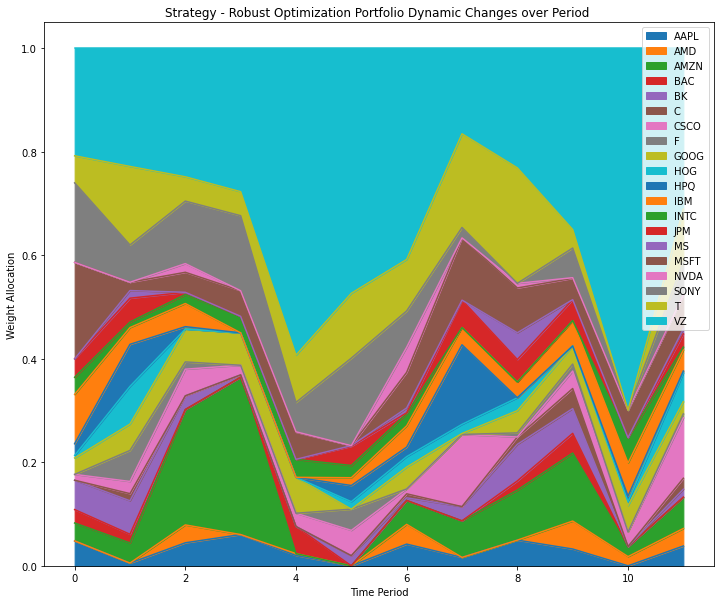

In [77]:

ax=df_stra7.plot.area(figsize=(12,10),label='a')
ax.legend(loc=1)
ax.set_xlabel("Time Period")
ax.set_ylabel("Weight Allocation")
ax.set_title('Strategy - Robust Optimization Portfolio Dynamic Changes over Period ')

In [78]:
# Q3. (25 %) Test for 2008 and 2009

In [111]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
#r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf = 0.045 #2008-2009

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat =len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
weight_opt = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
portf_value_each_period = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
borrow_amount = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         payback=0.0
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]
         payback=borrow_amount[strategy, period-2]
        


      
 #subtract the borrow asset because it shall be paid back by end of each period
                      #when calculating p_values for leverage ERC method so that each strategy can be compared properly
      if strategy==5:
            # Compute strategy
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1],borrow_amount[strategy, period-1],portf_value_each_period[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices,payback)
            # Compute portfolio value
         p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]-borrow_amount[strategy, period-1]
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
         print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      else:
            # Compute strategy
         x[strategy, period-1], cash[strategy, period-1],weight_opt[strategy, period-1],portf_value_each_period[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
            # Compute portfolio value
         p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
         print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        
        
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)
    

##Q2 (20 %) Analyze your results:
#Produce the following output for the 12 periods (years 2020 and 2021):



Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381648.04, value end = $ 326962.66
  Strategy "Mininum Variance Portfolio", value begin = $ 383268.36, value end = $ 327358.28
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381848.07, value end = $ 329332.59
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 380216.97, value end = $ 274750.78
  Strategy "Robust Optimization Portfolio", value begin = $ 382277.92, value end = $ 332345.80

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322092.27, value end = $ 354773.31
  Strategy "Mininum

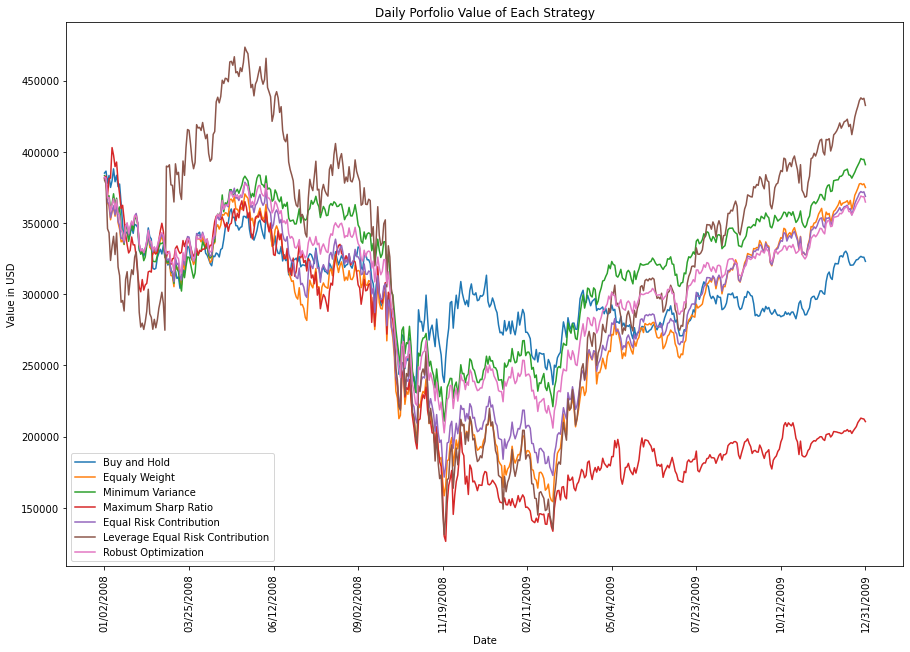

In [112]:
plt.figure(figsize=(15,10))

plt.xlabel('Date')
plt.ylabel('Value in USD')
plt.plot(dates,portf_value[0],label='Buy and Hold')
plt.plot(dates,portf_value[1],label='Equaly Weight')
plt.plot(dates,portf_value[2],label='Minimum Variance')
plt.plot(dates,portf_value[3],label='Maximum Sharp Ratio')
plt.plot(dates,portf_value[4],label='Equal Risk Contribution')
plt.plot(dates,portf_value[5],label='Leverage Equal Risk Contribution')
plt.plot(dates,portf_value[6],label='Robust Optimization')
plt.title('Daily Porfolio Value of Each Strategy')
plt.xticks(list(dates[k] for k in list(np.linspace(0,504,10,dtype=int))),rotation=90)
plt.legend()
plt.show()

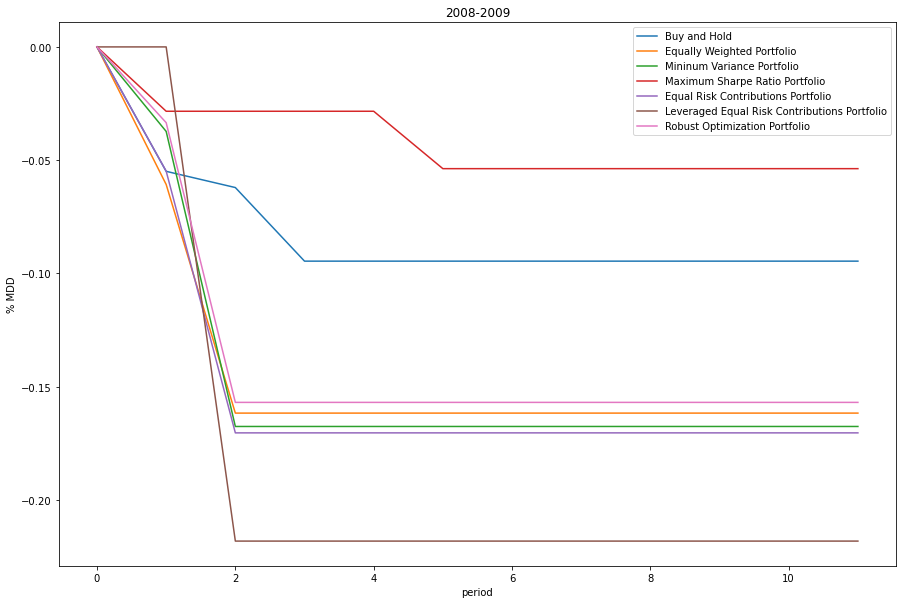

In [113]:
plt.figure(figsize=(15,10))
plt.ylabel('% MDD')
plt.xlabel('period')
plt.title('2008-2009')

for i in range (7):
    temp_letter=strategy_names[i]
    
    Roll_Max = df_portvalue[temp_letter].rolling(12, min_periods=1).max()
    Daily_Drawdown = df_portvalue[temp_letter]/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.rolling(12, min_periods=1).min()

    Max_Daily_Drawdown.plot(label=temp_letter)
    plt.legend()
 

plt.show()

Text(0.5, 1.0, 'Strategy - Robust Optimization Portfolio Dynamic Changes over Period ')

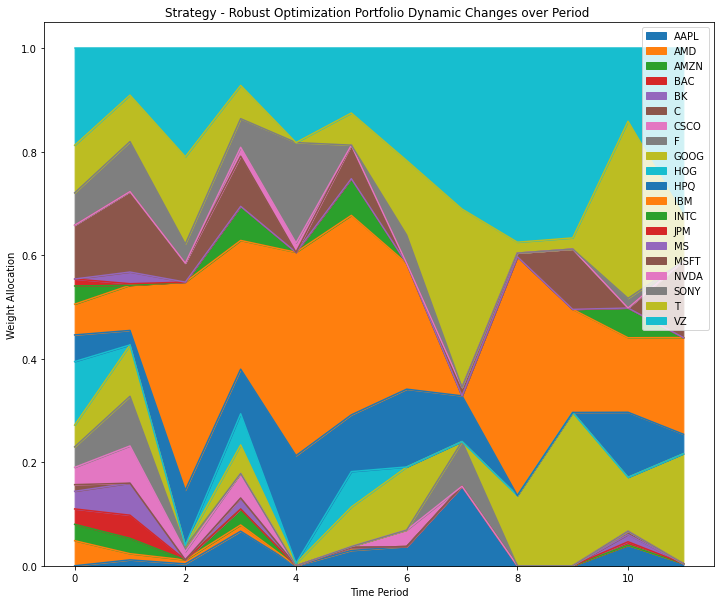

In [114]:
df_stra7=pd.DataFrame(weight_opt[6].tolist(),columns=stock_name)
ax=df_stra7.plot.area(figsize=(12,10),label='a')
ax.legend(loc=1)
ax.set_xlabel("Time Period")
ax.set_ylabel("Weight Allocation")
ax.set_title('Strategy - Robust Optimization Portfolio Dynamic Changes over Period ')

Text(0.5, 1.0, 'Strategy - Minimum Variance Dynamic Changes in Portfolio over Period')

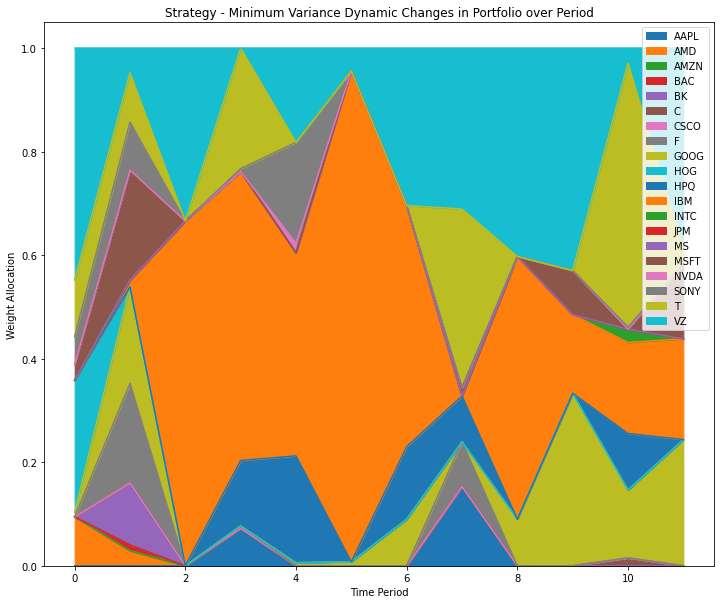

In [115]:
df_stra3=pd.DataFrame(weight_opt[2].tolist(),columns=stock_name)
ax=df_stra3.plot.area(figsize=(12,10),label='a')
ax.legend(loc=1)
ax.set_xlabel("Time Period")
ax.set_ylabel("Weight Allocation")
ax.set_title('Strategy - Minimum Variance Dynamic Changes in Portfolio over Period')

Text(0.5, 1.0, 'Strategy - Maximum Sharp Ratio Dynamic Changes in Portfolio over Period')

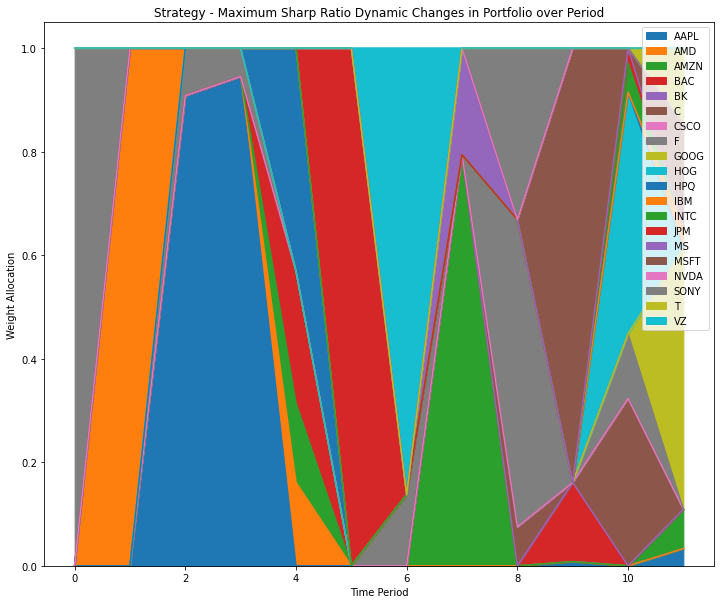

In [116]:
df_stra4=pd.DataFrame(weight_opt[3].tolist(),columns=stock_name)
ax=df_stra4.plot.area(figsize=(12,10),label='a')
ax.legend(loc=1)
ax.set_xlabel("Time Period")
ax.set_ylabel("Weight Allocation")
ax.set_title('Strategy - Maximum Sharp Ratio Dynamic Changes in Portfolio over Period')